In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
from tqdm import tqdm_notebook
from skimage.io import imread, imshow
from skimage.transform import resize
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

from pathlib import Path

## Get paths for images and sort them

In [3]:

path = 'data/DRIVE/'
path_test = 'test/images'
path_test_mask = 'test/1st_manual'
path_train = 'training/images_gray'
path_train_mask = 'training/manual'

img_path = Path(os.path.join(path, path_train))
mask_path = Path(os.path.join(path, path_train_mask))
test_img_path = Path(os.path.join(path, path_test))
test_mask_path = Path(os.path.join(path, path_test_mask))

#sort images to line up train and mask
img_names = []
mask_names = []
test_img_names = []
test_mask_names = []
for img, mas, test_img, test_mask in zip(img_path.iterdir(), mask_path.iterdir(),
                                         test_img_path.iterdir(),
                                         test_mask_path.iterdir()):
    img_names.append(str(img))
    mask_names.append(str(mas))
    test_img_names.append(str(test_img))
    test_mask_names.append(str(test_mask))
    
mask_names.sort()
img_names.sort()
test_img_names.sort()
test_mask_names.sort()

In [4]:
len(test_img_names)

20

(584, 565)
(584, 565)


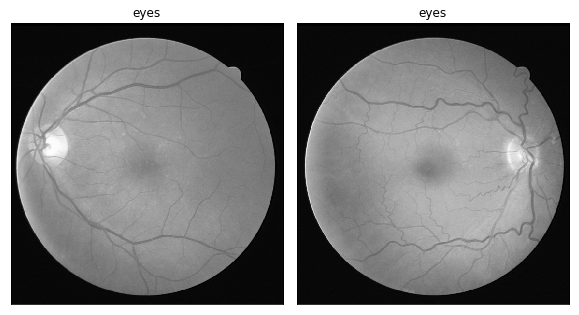

(584, 565)
(584, 565)


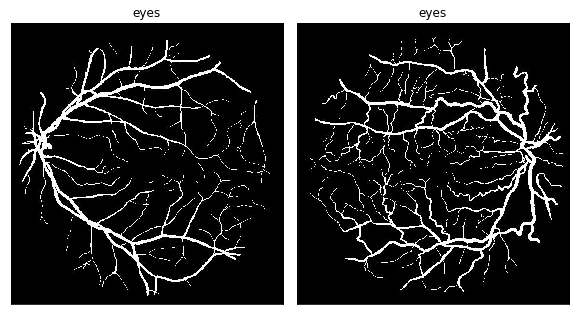

In [5]:
##show first two images 
def showImg(p):
    fig, axes = plt.subplots(1, 2, figsize=(10,10),
                         subplot_kw={'xticks': [], 'yticks': []})
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for ax, i in zip(axes.flat, range(2)):
        img = imread(p[i])
        ax.imshow(img, cmap='gray')
        ax.set_title('eyes')  
        print(img.shape)
    plt.show()
    
showImg(img_names)
showImg(mask_names)


### Resize and flip images

In [6]:
im_width = 560
im_height = 560
im_chan = 3
X_train = np.zeros((len(img_names)*3, im_height, im_width, 1), dtype=np.uint8)
Y_train = np.zeros((len(img_names)*3, im_height, im_width, 1), dtype=np.bool_)
X_test = np.zeros((len(img_names), im_height, im_width, 1), dtype=np.uint8)

print('Getting and resizing train images and masks ... ')

counter = 0
for i in tqdm_notebook(range(len(img_names))):
    img = imread(img_names[i])
    x = resize(img, (im_height, im_width, 1), mode='constant', preserve_range=True)
    X_train[counter] = x
     
    mask = imread(mask_names[i])
    m_ = np.zeros_like(mask)
    for k in range(584):
        for j in range(564):
            if mask[k][j]>50 :
                m_[k][j] = 1
    
    mask = resize(m_, (im_height, im_width, 1), mode='constant', preserve_range=True) 
    Y_train[counter] = mask    
    counter += 1
    
    #mod image and mask together
    X_train[counter] = np.fliplr(x)
    Y_train[counter] = np.fliplr(mask)
    
    counter +=1
    
    X_train[counter] = np.flipud(x)
    Y_train[counter] = np.flipud(mask)    
    counter +=1
    
    #resize for test images
    test_img = imread(test_img_names[i])
    test_img = resize(test_img, (im_height, im_width, 1), mode='constant', preserve_range=True)
    X_test[i] = test_img
   
print('Done!')

Getting and resizing train images and masks ... 


/home/tony/anaconda3/envs/torch/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/tony/anaconda3/envs/torch/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)



Done!


In [7]:
X_train[0].shape

(560, 560, 1)

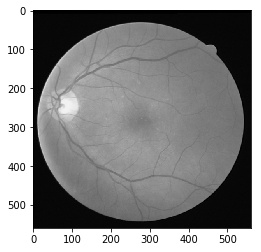

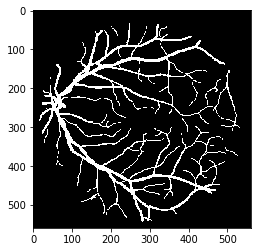

In [8]:
#resized images
ix = 0
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

### Create dataset

In [9]:
class eye_dataset(Dataset):

    def __init__(self,preprocessed_images, train=True, preprocessed_masks=None):
       
        self.train = train
        self.images = preprocessed_images
        if self.train:
            self.masks = preprocessed_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = None
        if self.train:
            mask = self.masks[idx]
            return (image, mask)
        return image

In [10]:
X_train[0].shape

(560, 560, 1)

In [11]:
#reshape
X_train_shaped = X_train.reshape(-1, 1, 560, 560)/255
Y_train_shaped = Y_train.reshape(-1, 1, 560, 560)

X_test_shaped = X_test.reshape(-1,1, 560, 560)/255

In [12]:
X_train_shaped = X_train_shaped.astype(np.float32)
Y_train_shaped = Y_train_shaped.astype(np.float32)

X_test_shaped = X_test_shaped.astype(np.float32)

In [13]:
X_train_shaped[0].shape

(1, 560, 560)

In [14]:
X_test_shaped[0].shape

(1, 560, 560)

In [15]:
#split
idx = list(range(60))
train_idxs = idx[:40]
val_idxs = idx[40:]

In [16]:
eye_dataset_train = eye_dataset(X_train_shaped[train_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped[train_idxs])
eye_dataset_val = eye_dataset(X_train_shaped[val_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped[val_idxs])

eye_test_dataset = eye_dataset(X_test_shaped[:10], train=False)

batch_size = 8

train_loader = torch.utils.data.DataLoader(dataset=eye_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=eye_dataset_val, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=eye_test_dataset, batch_size=batch_size,
                                         shuffle=False)

In [17]:
def conv_layer(chanIn, chanOut, ks = 3, stride=1):
    return nn.Sequential(
        nn.Conv2d(chanIn, chanOut, ks, stride, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(chanOut)
        )

class Conv_block(nn.Module):
    def __init__(self, chanIn, chanOut, pool = False):
        super().__init__()
        
        self.conv1 = conv_layer(chanIn, chanOut)
        self.conv2 = conv_layer(chanOut, chanOut)
        
    def forward(self, x) : 
        x = self.conv1(x)
        x = self.conv2(x)
        return x
        
class Mid_block(nn.Module):
    def __init__(self, chanIn, chanOut, ks=3, stride=1):
        super().__init__()        
        self.conv1 = nn.Conv2d(chanIn, chanOut, ks, padding=1)
        self.conv2 = nn.Conv2d(chanOut, chanOut, ks, padding=1)
        
    def forward(self, x) : 
        x = self.conv1(x)
        x = self.conv2(x)
        return x
  

class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        
        self.down1 = Conv_block(1,16)
        self.down2 = Conv_block(16, 32)
        self.down3 = Conv_block(32,64)
        self.down4 = Conv_block(64,128)
        
        self.mid = Mid_block(128,256)
        
        self.upt3 = nn.ConvTranspose2d(256,128,2,2)
        self.up3 =Conv_block(256,128)
        self.upt2 = nn.ConvTranspose2d(128, 64,2,2)
        self.up2 = Conv_block(128,64)
        self.upt1 = nn.ConvTranspose2d(64, 32,2,2)
        self.up1 = Conv_block(64,32)
        self.upt0 = nn.ConvTranspose2d(32, 16,2,2)
        self.up0 = Conv_block(32,16)
        self.last = nn.Conv2d(16,1,1)
        
        self.maxPool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout2d(p=.25, inplace=True)
        
    
    def forward(self, x):
        x1 = self.down1(x)
        p1 = self.maxPool(x1)
        p1 = self.dropout(p1)
        
        x2 = self.down2(p1)
        p2 = self.maxPool(x2)
        p2 = self.dropout(p2)
        
        x3 = self.down3(p2)
        p3 = self.maxPool(x3)
        p3 = self.dropout(p3)
        
        x4 = self.down4(p3)
        p4 = self.maxPool(x4)
        p4 = self.dropout(p4)
        
        xmid = self.mid(p4)
        
        xu3 = self.upt3(xmid)
        cat3 = torch.cat([x4, xu3],1)
        xu3 = self.up3(cat3)
        
        xu2 = self.upt2(xu3)
        cat2 = torch.cat([x3, xu2],1)
        xu2 = self.up2(cat2)
                
        xu1 = self.upt1(xu2)
        cat1 = torch.cat([x2,xu1],1)
        xu1 = self.up1(cat1)
        
        xu0 = self.upt0(xu1)
        cat0 = torch.cat([x1,xu0],1)
        xu0 = self.up0(cat0)
        return self.last(xu0)

In [18]:
model = Unet()
model.cuda()

criterion = nn.BCEWithLogitsLoss()

learning_rate = 0.01

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', 
                                                       factor=0.1, 
                                                       patience=8,
                                                       threshold=.000001, 
                                                       verbose=True)


In [19]:
mean_train_losses = []
mean_val_losses = []
for epoch in range(200):
    train_losses = []
    val_losses = []
    for images, masks in train_loader:        
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        
        outputs = model(images)        
        
        loss = criterion(outputs, masks)
        train_losses.append(loss.data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    for images, masks in val_loader:
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        val_losses.append(loss.data)
    
    
    mean_train_losses.append(np.mean(train_losses))
    mean_val_losses.append(np.mean(val_losses))
    scheduler.step(mean_val_losses[epoch])
    
    # Print Loss
    print('Epoch: {}. Train Loss: {}. Val Loss: {}'.format(epoch+1, np.mean(train_losses), np.mean(val_losses)))

torch.save(model.state_dict(), 'data/eyeResults/unet_1.pth' )

Epoch: 1. Train Loss: 0.6155163645744324. Val Loss: 0.5453875660896301
Epoch: 2. Train Loss: 0.5257644653320312. Val Loss: 0.46840181946754456
Epoch: 3. Train Loss: 0.4450368285179138. Val Loss: 0.3893786370754242
Epoch: 4. Train Loss: 0.3623090386390686. Val Loss: 0.3051305115222931
Epoch: 5. Train Loss: 0.2840803265571594. Val Loss: 0.2341775745153427
Epoch: 6. Train Loss: 0.2292763739824295. Val Loss: 0.19401949644088745
Epoch: 7. Train Loss: 0.18779870867729187. Val Loss: 0.17126846313476562
Epoch: 8. Train Loss: 0.1739886999130249. Val Loss: 0.15684716403484344
Epoch: 9. Train Loss: 0.16351863741874695. Val Loss: 0.15666954219341278
Epoch: 10. Train Loss: 0.15737763047218323. Val Loss: 0.14952506124973297
Epoch: 11. Train Loss: 0.15619812905788422. Val Loss: 0.1466178447008133
Epoch: 12. Train Loss: 0.15245524048805237. Val Loss: 0.1423306167125702
Epoch: 13. Train Loss: 0.1510227620601654. Val Loss: 0.14210979640483856
Epoch: 14. Train Loss: 0.14916953444480896. Val Loss: 0.13936

Epoch: 112. Train Loss: 0.1061919555068016. Val Loss: 0.10911428928375244
Epoch: 113. Train Loss: 0.10617657750844955. Val Loss: 0.11079061031341553
Epoch: 114. Train Loss: 0.10489171743392944. Val Loss: 0.10871455818414688
Epoch: 115. Train Loss: 0.10507333278656006. Val Loss: 0.10960552841424942
Epoch: 116. Train Loss: 0.10575630515813828. Val Loss: 0.1082257628440857
Epoch: 117. Train Loss: 0.10473613440990448. Val Loss: 0.10890036821365356
Epoch: 118. Train Loss: 0.10446830093860626. Val Loss: 0.10832536220550537
Epoch: 119. Train Loss: 0.10461513698101044. Val Loss: 0.10854664444923401
Epoch: 120. Train Loss: 0.1053829938173294. Val Loss: 0.10861965268850327
Epoch: 121. Train Loss: 0.10611177980899811. Val Loss: 0.10918029397726059
Epoch: 122. Train Loss: 0.10568755865097046. Val Loss: 0.10939902812242508
Epoch: 123. Train Loss: 0.10439882427453995. Val Loss: 0.10851820558309555
Epoch: 124. Train Loss: 0.10497201979160309. Val Loss: 0.108054518699646
Epoch: 125. Train Loss: 0.1043

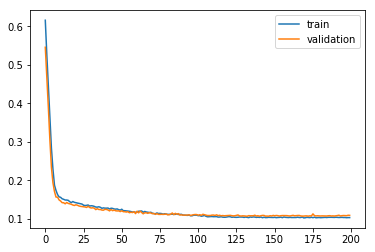

In [20]:
train_loss_series = pd.Series(mean_train_losses)
val_loss_series = pd.Series(mean_val_losses)
train_loss_series.plot(label="train")
val_loss_series.plot(label="validation")
plt.legend()

In [21]:
res = []
for im in test_loader:
    image = Variable(im.type(torch.FloatTensor).cuda())
    y_pred = model(image)
    res.append(y_pred)

In [22]:
res[0][0].shape

torch.Size([1, 560, 560])

In [23]:
result =res[0][0].reshape(560, 560,-1)

In [24]:
result.shape

torch.Size([560, 560, 1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


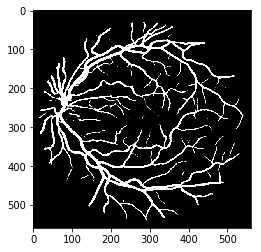

In [25]:
res1 = result.data.cpu().numpy()
res1 = np.squeeze(res1).astype(np.float32)
plt.imshow(np.dstack((res1,res1,res1)))

/home/tony/anaconda3/envs/torch/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


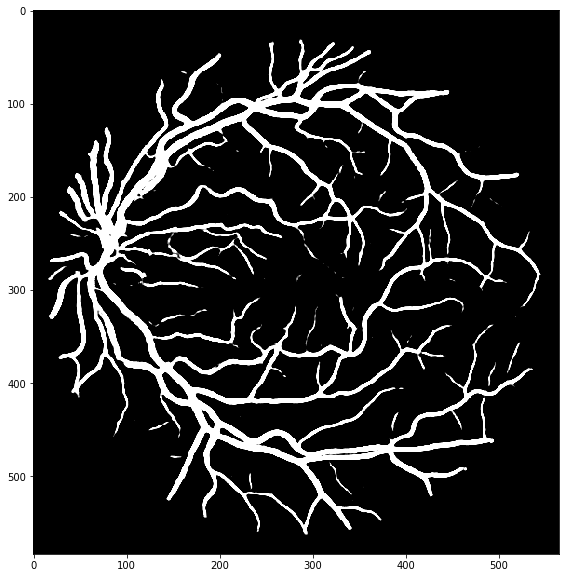

In [26]:
def res_show(img):
    result = img.reshape(560,560,-1)
    result = result.data.cpu().numpy()
    result = np.squeeze(result).astype(np.float32)
    x = resize(result, (584, 565, 1), mode='constant', preserve_range=True)
    x = np.squeeze(x).astype(np.float32)
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(111)
    ax1.imshow(np.dstack((x,x,x)))
    plt.show()

res_show(res[0][0])

In [27]:
model = Unet()
state_dict = torch.load('data/eyeResults/res_sep11.pth')
model.load_state_dict(state_dict)

In [28]:
model.eval()

Unet(
  (down1): Conv_block(
    (conv1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (down2): Conv_block(
    (conv1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (down3): Conv_block(
    (conv1): Sequential(
      (0): Conv2d(32, 64,

In [29]:
res =[]
for im in test_loader:
    image = Variable(im.type(torch.FloatTensor))
    #image = image.unsqueeze(0)
    print(image.shape)
    y_pred = model(image)
    res.append(y_pred)

torch.Size([8, 1, 560, 560])
torch.Size([2, 1, 560, 560])


/home/tony/anaconda3/envs/torch/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


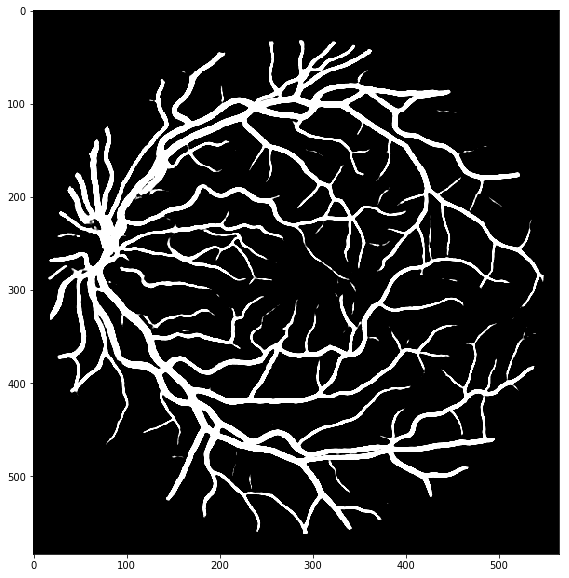

In [30]:
def res_show(img):
    result = img.reshape(560,560,-1)
    result = result.data.cpu().numpy()
    result = np.squeeze(result).astype(np.float32)
    x = resize(result, (584, 565, 1), mode='constant', preserve_range=True)
    x = np.squeeze(x).astype(np.float32)
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(111)
    ax1.imshow(np.dstack((x,x,x)))
    plt.show()

res_show(res[0][0])